In [ ]:
!pip install simpletransformers

In [ ]:
import io
import regex as re
import string

import matplotlib.pyplot as plt
import numpy as np
import nltk
import nltk.data
import pandas as pd
import seaborn as sns
import sklearn
import spacy



from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score  
from sklearn.model_selection import train_test_split


pd.set_option('display.max_colwidth', None)

In [ ]:
df_train_datathon = pd.read_pickle("./data/df_train.pickle")
df_test_datathon = pd.read_pickle("./data/df_test.pickle")
df_paper_tweets = pd.read_csv("./data/paper_input_tweets.csv", sep="|", index_col=0)
df_train_datathon_orig = pd.read_csv("./data/labels_racism.csv", sep="|")
df_aug_tweets = pd.read_pickle("./data/df_aug_lbl.pickle")

In [ ]:
print("-------------TRAINING------------------")
print(f'Columns: {df_train_datathon.columns}')
print(f'Shape: {df_train_datathon.shape}')


print("-------------TRAINING original------------------")
df_train_datathon_orig['lemma_str'] = df_train_datathon_orig['message']
df_train_datathon_orig['final_label'] = df_train_datathon_orig['label']
print(f'Columns: {df_train_datathon_orig.columns}')
print(f'Shape: {df_train_datathon_orig.shape}')


print("-------------TEST------------------")
print(f'Columns: {df_test_datathon.columns}')
print(f'Shape: {df_test_datathon.shape}')


print("-------------paper------------------")
df_paper_tweets['message'] = df_paper_tweets['text']
df_paper_tweets['lemma_str'] = df_paper_tweets['text']
df_paper_tweets['final_label'] = df_paper_tweets['target'].map({1: "racist", 0: "non-racist"})
print(f'Columns: {df_paper_tweets.columns}')
print(f'Shape: {df_paper_tweets.shape}')


print("-------------augmented------------------")
print(f'Columns: {df_aug_tweets.columns}')
print(f'Shape: {df_aug_tweets.shape}')

-------------TRAINING------------------
Columns: Index(['message', 'final_label', 'support_label', 'tokenized', 'lower',
       'no_punc', 'stopwords_removed', 'pos_tags', 'wordnet_pos', 'lemmatized',
       'lemma_str', 'stemm', 'stemm_str', 'lemma_spacy', 'lemma_spacy_str',
       'tweet_len', 'word_count'],
      dtype='object')
Shape: (5672, 17)
-------------TRAINING original------------------
Columns: Index(['message', 'labeller_id', 'label', 'lemma_str', 'final_label'], dtype='object')
Shape: (9291, 5)
-------------TEST------------------
Columns: Index(['message', 'final_label', 'support_label', 'tokenized', 'lower',
       'no_punc', 'stopwords_removed', 'pos_tags', 'wordnet_pos', 'lemmatized',
       'lemma_str', 'stemm', 'stemm_str', 'lemma_spacy', 'lemma_spacy_str',
       'tweet_len', 'word_count'],
      dtype='object')
Shape: (59, 17)
-------------paper------------------
Columns: Index(['text', 'target', 'message', 'lemma_str', 'final_label'], dtype='object')
Shape: (2000,

In [ ]:
#df_aug_tweets.head(1)
#df_paper_tweets.head(1)
#df_train_datathon.head(1)
#df_test_datathon.head(1)
#df_train_datathon_orig.head(1)

# Predict unknown labels of training with XGBOOST model



In [ ]:
import pickle
from xgboost import XGBClassifier

xgb_model_loaded = pickle.load(open("./models/xgb_reg_best.pkl", "rb"))
tfidf_vectorizer = pickle.load(open("./models/xgb_tfidf_vec_best.pkl", "rb"))


tfidf_public = tfidf_vectorizer.transform(df_train_datathon['stemm_str'])
X_public = tfidf_public.toarray()
df_train_datathon['pred_xgb'] = xgb_model_loaded.predict(X_public)

tfidf_public = tfidf_vectorizer.transform(df_train_datathon_orig['lemma_str'])
X_public = tfidf_public.toarray()
df_train_datathon_orig['pred_xgb'] = xgb_model_loaded.predict(X_public)

tfidf_public = tfidf_vectorizer.transform(df_aug_tweets['lemma_str'])
X_public = tfidf_public.toarray()
df_aug_tweets['pred_xgb'] = xgb_model_loaded.predict(X_public)

In [ ]:
for index, row in df_train_datathon.iterrows():
  if row['final_label'] == 'unknown':
    df_train_datathon.loc[index, 'final_label'] = "racist" if row['pred_xgb'] == 1 else "non-racist"

for index, row in df_train_datathon_orig.iterrows():
  if row['final_label'] == 'unknown':
    df_train_datathon_orig.loc[index, 'final_label'] = "racist" if row['pred_xgb'] == 1 else "non-racist"

for index, row in df_aug_tweets.iterrows():
  if row['final_label'] == 'unknown':
    df_aug_tweets.loc[index, 'final_label'] = "racist" if row['pred_xgb'] == 1 else "non-racist"

Join all datasets to create a new big one

In [ ]:
#list dataframe you want to append
df_list = [df_train_datathon, df_test_datathon, df_paper_tweets, df_aug_tweets, df_train_datathon_orig]   

#new dataframe to store append result
df_new_dataset = pd.DataFrame()

for df in df_list:
    df_new_dataset = df_new_dataset.append(df)

In [ ]:
print("-------------new dataset------------------")
print(f'Columns: {df_new_dataset.columns}')
print(f'Shape: {df_new_dataset.shape}')

-------------new dataset------------------
Columns: Index(['message', 'final_label', 'support_label', 'tokenized', 'lower',
       'no_punc', 'stopwords_removed', 'pos_tags', 'wordnet_pos', 'lemmatized',
       'lemma_str', 'stemm', 'stemm_str', 'lemma_spacy', 'lemma_spacy_str',
       'tweet_len', 'word_count', 'pred_xgb', 'text', 'target', 'labeller_id',
       'label'],
      dtype='object')
Shape: (17324, 22)


Sepparate into Training and Test 95/5

In [ ]:
from sklearn.model_selection import train_test_split

df_clean_selection = df_new_dataset[['message','lemma_str','final_label']]

df_train, df_test = train_test_split(df_clean_selection, test_size = 0.05, random_state = 42)

print(f'Training set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')

Training set shape: (16457, 3)
Test set shape: (867, 3)


In [ ]:
df_train.head()

,message,lemma_str,final_label
4280,Que no llegue el 15 de mayo de 2021 y tengamos que recurrir a El País o La Razón para que nos cuenten qué fue y para qué sirvió aquella lucha. Ayúdanos a hacer posible #15Mpodcast en @goteofunding: @SuNotissima @patriciasimon @galapita @PDLI_,llegue 15 mayo 2021 recurrir país razón cuenten sirvió aquella lucha ayúdanos hacer posible #15mpodcast @goteofunding @sunotissima @patriciasimon @galapita @pdli_,non-racist
5979,@alfonfrias Fascistas!!! Los menas no son delincuentes!!!!,@alfonfrias Fascistas!!! Los menas no son delincuentes!!!!,non-racist
1593,"@carlos19sv @_elfaro_ @nayibbukele yo opino qué hay que deportar a todos los inmigrantes ilegales que están en nuestro país el salvador 🇸🇻 lucrándose, y violando las leyes salvadoreñas. en usa 🇺🇸 si no tienes estatus legal para trabajar . te ecuentras con ice te deportan",@carlos19sv @_elfaro_ @nayibbukele opino deportar inmigrantes ilegales país salvador 🇸 🇻 lucrándose violando leyes salvadoreñas usa 🇺 🇸 si estatus legal trabajar ecuentras ice deportan,racist
118,"@DiarioOle No, corrección. Sos un mala leche negro de mierda.","@DiarioOle No, corrección. Sos un mala leche negro de mierda.",racist
2760,Comienza la repatriación de 800 menas marroquíes llegados a Ceuta en mayo: las ONGs lo tachan de «ilegal»:,comienza repatriación 800 menas marroquíes llegados ceuta mayo ongs tachan « ilegal »,racist


In [ ]:
df_train['final_label'].unique()

array(['non-racist', 'racist'], dtype=object)

# Training model

In [ ]:
train_args ={"reprocess_input_data": True,
         "fp16":False,
          "num_train_epochs": 4,
             "do_lower_case": False}

model = ClassificationModel(
    "bert", 
    "dccuchile/bert-base-spanish-wwm-cased",
    use_cuda = True,
    args=train_args
)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [ ]:
df_train = df_new_dataset
new_messages = []
for index, row in df_train.iterrows():
  new_messages.append(row['lemma_str'] + " " + row['message'])
df_train['new_message'] = new_messages

In [ ]:
train_df = df_train[['new_message', 'final_label']]
train_df['final_label'] = train_df['final_label'].map({'racist': 1, 'non-racist': 0})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
model.train_model(train_df)

  0%|          | 0/17324 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/2166 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/2166 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/2166 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/2166 [00:00<?, ?it/s]

(8664, 0.3232058456920785)

# Testing model

In [ ]:
new_messages = []
for index, row in df_test.iterrows():
  new_messages.append(row['lemma_str'] + " " + row['message'])
df_test['new_message'] = new_messages
predictions, raw_outputs= model.predict(list(df_test['new_message']))
df_test['pred_label'] = predictions
df_test['pred_label'] = df_test['pred_label'].map({1:'racist', 0:'non-racist'})
f1_score(df_test['final_label'], df_test['pred_label'], average='macro')

  0%|          | 0/867 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

0.9456964550575497

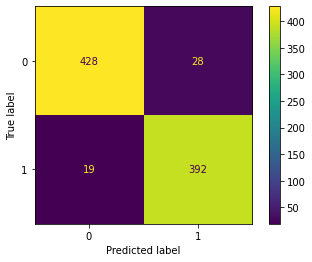

In [ ]:
cm = confusion_matrix(df_test['final_label'], df_test['pred_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
plt.show()

# Export model

In [ ]:
import os
import tarfile

def pack_model(model_path='',file_name=''):
    files = [files for root, dirs, files in os.walk(model_path)][0]
    with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
        for file in files:
            f.add(f'{model_path}/{file}')


pack_model('outputs','final_beto_big')